In [299]:
from fastai.vision.all import *
from PIL import Image, ImageDraw
from IPython.display import display
import random
from fastai.metrics import accuracy_multi



# Define paths
TRAIN_IMAGES_DIR = "train_images"
VAL_IMAGES_DIR = "val_images"
ANNOTATIONS_PATH = "annotations.txt"

There are 1587 annotations for 1587 images

Random image: screenshot1712745987.7510476.png
Random lbl_bbox: ([148.5, 379.5, 183.5, 414.5], 'ally')
Random bbox: [148.5, 379.5, 183.5, 414.5]
Random label: ['ally']


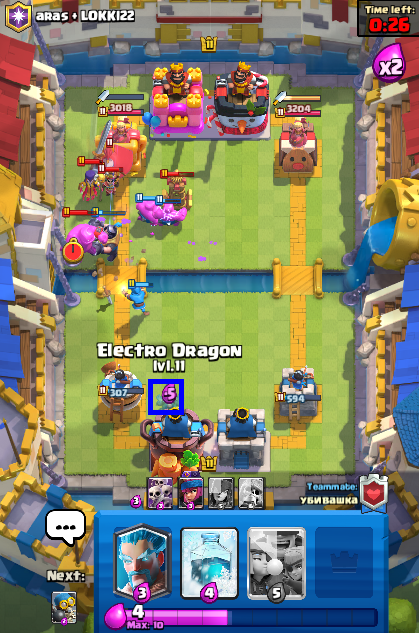


Random image: screenshot1712749004.1354022.png
Random lbl_bbox: ([127.5, 145.5, 162.5, 180.5], 'ally')
Random bbox: [127.5, 145.5, 162.5, 180.5]
Random label: ['ally']


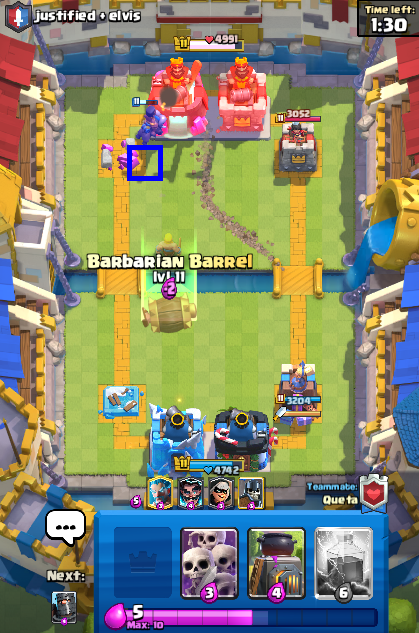

In [300]:
annotation_lines = open(ANNOTATIONS_PATH, "r").readlines()


def _get_annotations(image_dir):
    # imgs = [
    #     '8973245.jpg',
    #     '6433463.jpg',
    #     '2342342.jpg',
    # ]
    # lbl_bbox = ([[155,96,351,270],'car'])

    # get all images
    imgs = os.listdir(image_dir)
    paths = []
    for name in imgs:
        paths.append(name)

    # get all the annotaion lines in order of the images
    ordered_annotation_lines = []
    for image_name in imgs:
        this_annotation = None
        for annotation_line in annotation_lines:
            parts = annotation_line.split()
            annotation_file_name = parts[0]
            if image_name in annotation_file_name:
                this_annotation = annotation_line
                ordered_annotation_lines.append(this_annotation)
        if this_annotation is None:
            print(f"THIS IMAGE NAME LACKS AN ANNOTATION: {image_name}")

    print(
        f"There are {len(ordered_annotation_lines)} annotations for {len(imgs)} images"
    )

    # get all bboxes
    bboxs = []

    for annotation_line in ordered_annotation_lines:
        parts = annotation_line.split(",")
        bbox = [
            (float(parts[2])),
            (float(parts[3])),
            (float(parts[4])),
            (float(parts[5].replace("\n", ""))),
        ]
        bboxs.append(bbox)

    lbl_bbox = []
    for i, bbox in enumerate(bboxs):
        label = ordered_annotation_lines[i].split(",")[1]
        if label == "0":
            label = "enemy"
        elif label == "1":
            label = "ally"
        datum = bbox, label
        lbl_bbox.append(datum)

    return imgs, lbl_bbox


# method to draw a bounding box on an image
def draw_bbox(image_path, bbox, color="red", thickness=5):
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)
    draw.rectangle(bbox, outline=color, width=thickness)
    return image


imgs, lbl_bbox = _get_annotations(TRAIN_IMAGES_DIR)

for _ in range(2):
    index = random.randint(0, len(imgs) - 1)
    print(f"\nRandom image: {imgs[index]}")
    print(f"Random lbl_bbox: {lbl_bbox[index]}")
    print(f"Random bbox: {lbl_bbox[index][0]}")
    label = [lbl_bbox[index][1]]
    print(f"Random label: {label}")
    color = "blue"
    if label == ["enemy"]:
        color = "red"
    image_with_bbox = draw_bbox(
        os.path.join("train_images", imgs[index]), lbl_bbox[index][0], color
    )
    display(image_with_bbox)

In [301]:
img2bbox = dict(zip(imgs,lbl_bbox))

print(img2bbox['screenshot1712747252.366341.png'])

([99.5, 324.5, 134.5, 359.5], 'ally')


In [302]:
getters = [
    lambda o: os.path.join(TRAIN_IMAGES_DIR, o),  # Concatenate directory path with image filename
    lambda o: img2bbox[o][0],
    lambda o: [img2bbox[o][1]]
]


In [303]:
item_tfms = [Resize(224)]
# batch_tfms = [Rotate(),Flip(), Dihedral(),Normalize.from_stats(*imagenet_stats)]
batch_tfms = [Normalize.from_stats(*imagenet_stats)]


In [304]:
def get_train_imgs(noop):
    return imgs

In [305]:
pascal = DataBlock(
    blocks = (ImageBlock, BBoxBlock, BBoxLblBlock),
    splitter = RandomSplitter(),
    get_items = get_train_imgs,
    getters = getters,
    item_tfms = item_tfms,
    batch_tfms = batch_tfms,
    n_inp = 1
)

dls = pascal.dataloaders(TRAIN_IMAGES_DIR)

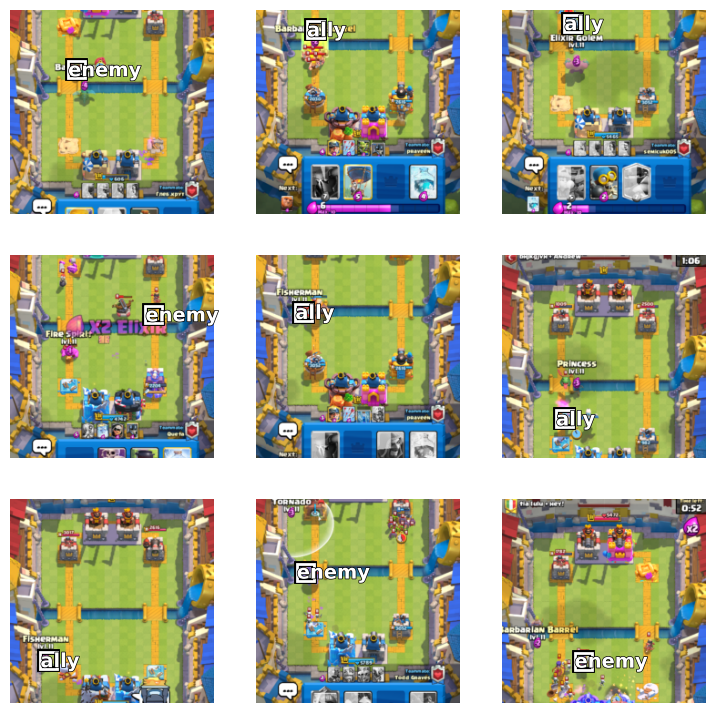

In [306]:
dls.c = 20
dls.show_batch()

In [307]:
# method to get the current date and time so we can save the model with a unique name
def get_current_date_time():
    now = datetime.now()
    dt_string = now.strftime("%d_%m_%Y_%H_%M_%S")
    return dt_string


# test the datetime function
print(get_current_date_time())

13_05_2024_22_50_34


In [321]:
!git clone https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0.git
%cd "Practucak-Deep-Learning-for-Coders-2.0/Computer Vision"

[WinError 3] The system cannot find the path specified: 'Practucak-Deep-Learning-for-Coders-2.0/Computer Vision'
c:\My Files\my Programs\clash\troop_detecter


fatal: destination path 'Practical-Deep-Learning-for-Coders-2.0' already exists and is not an empty directory.
C:\Users\matt\AppData\Roaming\Python\Python311\site-packages\IPython\core\magics\osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


In [6]:
from helper_folder.computer_vision.EfficientNet_and_Custom_Weights import create_body

encoder = create_body(resnet34, pretrained=True)
arch = RetinaNet(encoder, get_c(dls), final_bias=4)

ModuleNotFoundError: No module named 'helper_folder.computer_vision.EfficientNet_and_Custom_Weights'

In [1]:



learn = vision_learner(dls)
# learn = vision_learner(dls, resnet34, pretrained=True, metrics=COCOMetric)

NameError: name 'vision_learner' is not defined

In [309]:
lr = 0.002

learn = learn.to_fp16()
learn.fit_one_cycle(5, slice(lr))
learn.unfreeze()
learn.lr_find()
learn.fit_one_cycle(5, slice(1e-5, lr / 5))

# save the model
model_name = f"troop_detect_model_{get_current_date_time()}.pkl"
# model_name = f"multi_model_{get_current_date_time()}.onnx"
learn.export(model_name)

epoch,train_loss,valid_loss,optim_metric,time


TypeError: BaseLoss.__call__() takes 3 positional arguments but 4 were given

In [ ]:
learn.show_results(figsize=(15, 15))

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

interp.plot_confusion_matrix()

In [ ]:
#load the model
learn_inf = load_learner(r"multi_model_12_05_2024_19_09_41.pkl")

In [ ]:
#test the model

#get the true label for this image
path = os.path.join(IMAGE_PATH, random.choice(os.listdir(IMAGE_PATH)))
label = GetLabel(os.path.basename(path))

# get a random image
img = PILImage.create(path)
img.show()

print('True label:',label)

learn_inf.predict(img)
